## Conclusion
After several attempts, using both ARIMA and Prophet, we concluded this data is not ideal for time-serie predictions. We attempted removing outliers to make sure the data represents a general trend of the sales behavior, but still could not make the models to make accurate prediction. 

We can conclude that there are not enough trends presented in the data, this could be due to the company was constantly making random changes to their maketing strategies, making the sales data preseting random behaviors. Or the company replies purely on organic grow and there isn't enought data presented in the provided dataset for accurate time-series predictions.

In conclusion, time-series is not a good approach for this data, should use other means, regression or CNN.

In [80]:
# This block is from https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

#load packages
import sys #access to system parameters https://docs.python.org/3/library/sys.html
print("Python version: {}". format(sys.version))

import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
print("pandas version: {}". format(pd.__version__))

import matplotlib #collection of functions for scientific and publication-ready visualization
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np #foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))

import scipy as sp #collection of functions for scientific computing and advance mathematics
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 

import sklearn #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

import seaborn as sns #collection of functions for data visualization
print("seaborn version: {}". format(sns.__version__))

from sklearn.preprocessing import OneHotEncoder #OneHot Encoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
%matplotlib inline

#misc libraries
import random
import time
from pandas import datetime


#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "input"]).decode("utf8"))

Python version: 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
pandas version: 1.0.1
matplotlib version: 3.1.3
NumPy version: 1.18.1
SciPy version: 1.4.1
IPython version: 7.12.0
scikit-learn version: 0.22.1
seaborn version: 0.10.0
-------------------------
item_categories.csv
items.csv
sales_train.csv
sample_submission.csv
shops.csv
test.csv



In [81]:
item_categories = pd.read_csv('input/item_categories.csv')
items = pd.read_csv('input/items.csv')
sales_train_raw = pd.read_csv('input/sales_train.csv')
sample_submission = pd.read_csv('input/sample_submission.csv')
shops_raw = pd.read_csv('input/shops.csv')
test_raw = pd.read_csv('input/test.csv')

## There are a lot we can do with the data, but in this kernel we will focus on forcasting

In [82]:
sales_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


## From the info() above, we can see that date is interpreted as objects, let's do a proper read in

In [83]:
def parser(x):
    return datetime.strptime(x,'%d.%m.%Y')

sales_train_di = pd.read_csv('input/sales_train.csv', index_col= 0, parse_dates=[0] ,date_parser=parser)

In [84]:
sales_train_raw.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

In [85]:
sales_train_di.head()

date_block_num  shop_id  item_id  item_price  item_cnt_day
date                                                                  
2013-01-02               0       59    22154      999.00           1.0
2013-01-03               0       25     2552      899.00           1.0
2013-01-05               0       25     2552      899.00          -1.0
2013-01-06               0       25     2554     1709.05           1.0
2013-01-15               0       25     2555     1099.00           1.0

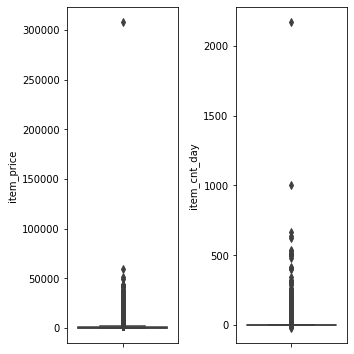

In [86]:
fig = plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
sns.boxplot(y='item_price', data=sales_train_di)
plt.subplot(1,2,2)
sns.boxplot(y='item_cnt_day', data=sales_train_di)
fig.tight_layout(pad=1.0)

In [87]:
sales_train_di.item_price = sales_train_di.item_price.apply(lambda x: 6000 if x > 10000 else x)
sales_train_di.item_cnt_day = sales_train_di.item_cnt_day.apply(lambda x: 700 if x > 700 else x)

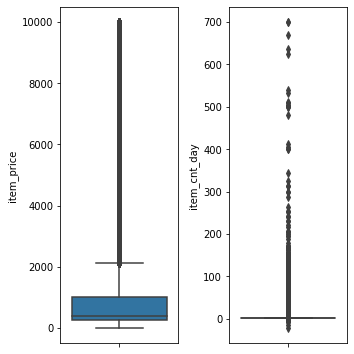

In [88]:
fig = plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
sns.boxplot(y='item_price', data=sales_train_di)
plt.subplot(1,2,2)
sns.boxplot(y='item_cnt_day', data=sales_train_di)
fig.tight_layout(pad=1.0)

## Next we work with this data to shape it into formats that we can work with before modeling

In [89]:
sales_train_di['sales'] = sales_train_di['item_price']*sales_train_di['item_cnt_day']

In [91]:
sales_train_di.index.value_counts()

2013-12-28    9434
2013-12-29    9335
2014-12-30    9324
2013-12-30    9138
2014-12-31    8347
              ... 
2015-05-14    1174
2015-04-28    1154
2015-10-06    1152
2015-05-13    1128
2015-05-12    1123
Name: date, Length: 1034, dtype: int64

### Observation

Looks like the data is seperated by date and item_id, meaning that it records the sale for a specific item on a specific date, we could group data by month

In [92]:
sales = sales_train_di.drop(['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day'], axis=1)

In [93]:
sales.head()

sales
date               
2013-01-02   999.00
2013-01-03   899.00
2013-01-05  -899.00
2013-01-06  1709.05
2013-01-15  1099.00

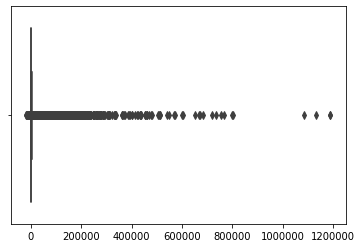

In [158]:
sns.boxplot(sales)

In [159]:
sales.sales = sales.sales.apply(lambda x: 800000 if x > 800000 else x)

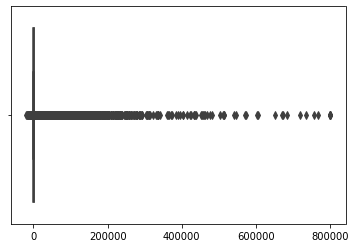

In [160]:
sns.boxplot(sales)

In [210]:
sales_gm = sales.resample("m").sum()

In [213]:
sales_gm

sales
date                    
2013-01-31  8.651898e+07
2013-02-28  8.700277e+07
2013-03-31  1.018187e+08
2013-04-30  6.661050e+07
2013-05-31  6.311707e+07
2013-06-30  7.708695e+07
2013-07-31  6.634901e+07
2013-08-31  7.140165e+07
2013-09-30  1.149376e+08
2013-10-31  1.037347e+08
2013-11-30  1.139218e+08
2013-12-31  1.654133e+08
2014-01-31  8.807252e+07
2014-02-28  8.682228e+07
2014-03-31  9.558498e+07
2014-04-30  7.218334e+07
2014-05-31  8.363290e+07
2014-06-30  7.429568e+07
2014-07-31  6.854293e+07
2014-08-31  7.883962e+07
2014-09-30  1.007450e+08
2014-10-31  1.014865e+08
2014-11-30  1.367453e+08
2014-12-31  1.894228e+08
2015-01-31  1.032075e+08
2015-02-28  7.987248e+07
2015-03-31  8.005460e+07
2015-04-30  8.626893e+07
2015-05-31  8.363315e+07
2015-06-30  5.993786e+07
2015-07-31  5.625582e+07
2015-08-31  5.758760e+07
2015-09-30  8.648525e+07
2015-10-31  7.757567e+07

In [211]:
sales_gm.size

34

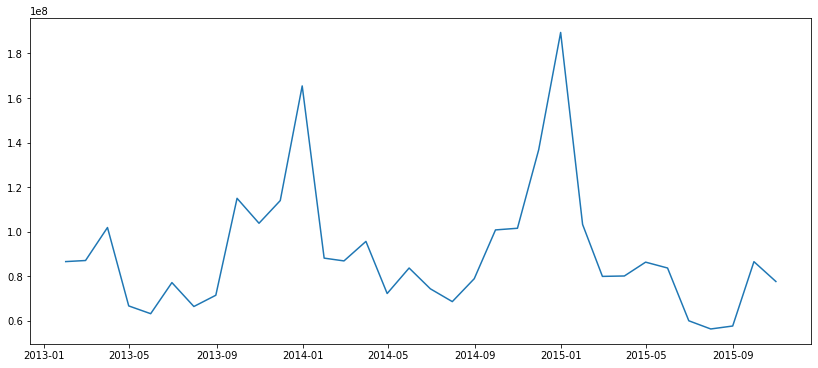

In [212]:
plt.figure(figsize=(14,6))
sns.lineplot(data=sales_gm.sales)

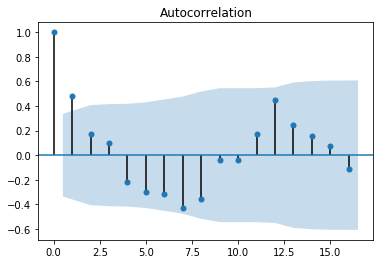

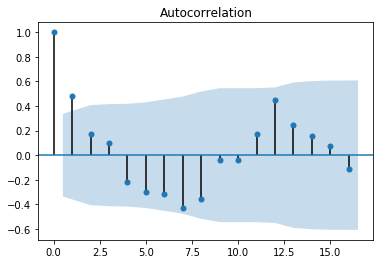

In [168]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(sales_gm.sales)

In [214]:
train_index_m = int(np.rint(sales_gm.size*0.8))

In [256]:
sales_gm

sales
date                    
2013-01-31  8.651898e+07
2013-02-28  8.700277e+07
2013-03-31  1.018187e+08
2013-04-30  6.661050e+07
2013-05-31  6.311707e+07
2013-06-30  7.708695e+07
2013-07-31  6.634901e+07
2013-08-31  7.140165e+07
2013-09-30  1.149376e+08
2013-10-31  1.037347e+08
2013-11-30  1.139218e+08
2013-12-31  1.654133e+08
2014-01-31  8.807252e+07
2014-02-28  8.682228e+07
2014-03-31  9.558498e+07
2014-04-30  7.218334e+07
2014-05-31  8.363290e+07
2014-06-30  7.429568e+07
2014-07-31  6.854293e+07
2014-08-31  7.883962e+07
2014-09-30  1.007450e+08
2014-10-31  1.014865e+08
2014-11-30  1.367453e+08
2014-12-31  1.894228e+08
2015-01-31  1.032075e+08
2015-02-28  7.987248e+07
2015-03-31  8.005460e+07
2015-04-30  8.626893e+07
2015-05-31  8.363315e+07
2015-06-30  5.993786e+07
2015-07-31  5.625582e+07
2015-08-31  5.758760e+07
2015-09-30  8.648525e+07
2015-10-31  7.757567e+07

In [274]:
sales_gm.size

34

In [275]:
train_index_m

27

In [276]:
X_train_m = sales_gm[:train_index_m]
X_train_m.size


27

In [277]:
X_train_m

sales
date                    
2013-01-31  8.651898e+07
2013-02-28  8.700277e+07
2013-03-31  1.018187e+08
2013-04-30  6.661050e+07
2013-05-31  6.311707e+07
2013-06-30  7.708695e+07
2013-07-31  6.634901e+07
2013-08-31  7.140165e+07
2013-09-30  1.149376e+08
2013-10-31  1.037347e+08
2013-11-30  1.139218e+08
2013-12-31  1.654133e+08
2014-01-31  8.807252e+07
2014-02-28  8.682228e+07
2014-03-31  9.558498e+07
2014-04-30  7.218334e+07
2014-05-31  8.363290e+07
2014-06-30  7.429568e+07
2014-07-31  6.854293e+07
2014-08-31  7.883962e+07
2014-09-30  1.007450e+08
2014-10-31  1.014865e+08
2014-11-30  1.367453e+08
2014-12-31  1.894228e+08
2015-01-31  1.032075e+08
2015-02-28  7.987248e+07
2015-03-31  8.005460e+07

In [278]:
X_test_m = sales_gm[train_index_m:]
X_test_m.size

7

In [279]:
X_test_m

sales
date                    
2015-04-30  8.626893e+07
2015-05-31  8.363315e+07
2015-06-30  5.993786e+07
2015-07-31  5.625582e+07
2015-08-31  5.758760e+07
2015-09-30  8.648525e+07
2015-10-31  7.757567e+07

In [280]:
import itertools
from statsmodels.tsa.arima_model import ARIMA

def hyper_p (train):
    best_aic = np.inf 
    best_param = None
    best_model = None
    
    p=d=q=range(0,12)
    pdq = list(itertools.product(p,d,q))

    for param in pdq:
        try:
            arima = ARIMA(train,order=param)
            arima_fit = model_arima.fit()
            if arima_fit.aic < best_aic:
                best_aic = arima_fit.aic
                best_param = param
                best_model = arima_fit
        except:
            continue

    print('aic: {:6.5f} | pdq set: {}'.format(best_aic, best_param))
    return best_model

In [281]:
best_arima = hyper_p (X_train_m)

aic: 946.39747 | pdq set: (0, 0, 0)


In [282]:
predictions_m= best_arima.forecast(steps=X_test_m.size)[0]
predictions_m

array([ 9.62590251e+06, -1.39023824e+07, -2.86523517e+07, -8.58639864e+07,
       -1.10700068e+08, -1.34051003e+08, -1.82532457e+08])

In [283]:
from sklearn.metrics import mean_squared_error
score = mean_squared_error(X_test_m, predictions_m)

In [284]:
score

2.68638305399709e+16

In [285]:
p_df = pd.DataFrame({'sale': predictions_m}, index = X_test_m.index)

In [286]:
p_df

sale
date                    
2015-04-30  9.625903e+06
2015-05-31 -1.390238e+07
2015-06-30 -2.865235e+07
2015-07-31 -8.586399e+07
2015-08-31 -1.107001e+08
2015-09-30 -1.340510e+08
2015-10-31 -1.825325e+08

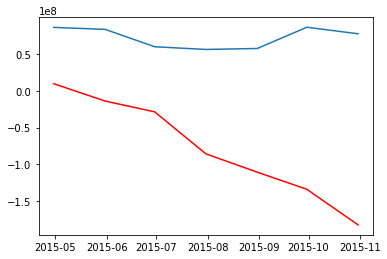

In [287]:
plt.plot(X_test_m)
plt.plot(p_df,color='red')

In [300]:
train_rindex = X_train_m.copy()

In [301]:
train_rindex.reset_index(level=0, inplace=True)

In [304]:
train_rindex.columns = ['ds', 'y']

In [305]:
train_rindex

ds             y
0  2013-01-31  8.651898e+07
1  2013-02-28  8.700277e+07
2  2013-03-31  1.018187e+08
3  2013-04-30  6.661050e+07
4  2013-05-31  6.311707e+07
5  2013-06-30  7.708695e+07
6  2013-07-31  6.634901e+07
7  2013-08-31  7.140165e+07
8  2013-09-30  1.149376e+08
9  2013-10-31  1.037347e+08
10 2013-11-30  1.139218e+08
11 2013-12-31  1.654133e+08
12 2014-01-31  8.807252e+07
13 2014-02-28  8.682228e+07
14 2014-03-31  9.558498e+07
15 2014-04-30  7.218334e+07
16 2014-05-31  8.363290e+07
17 2014-06-30  7.429568e+07
18 2014-07-31  6.854293e+07
19 2014-08-31  7.883962e+07
20 2014-09-30  1.007450e+08
21 2014-10-31  1.014865e+08
22 2014-11-30  1.367453e+08
23 2014-12-31  1.894228e+08
24 2015-01-31  1.032075e+08
25 2015-02-28  7.987248e+07
26 2015-03-31  8.005460e+07

In [306]:
#borrowed from https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts
from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(train_rindex) #fit the model with your dataframe

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.


In [307]:
future = model.make_future_dataframe(periods = 7, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)


In [308]:
forecast

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0  2013-01-31  9.823397e+07  8.303900e+07  8.796520e+07  9.823397e+07   
1  2013-02-28  9.853302e+07  8.671618e+07  9.146044e+07  9.853302e+07   
2  2013-03-31  9.886410e+07  1.015014e+08  1.063650e+08  9.886410e+07   
3  2013-04-30  9.918451e+07  6.328001e+07  6.825153e+07  9.918451e+07   
4  2013-05-31  9.951560e+07  5.905347e+07  6.399735e+07  9.951560e+07   
5  2013-06-30  9.983597e+07  7.272938e+07  7.792469e+07  9.983597e+07   
6  2013-07-31  1.001666e+08  6.223752e+07  6.712368e+07  1.001666e+08   
7  2013-08-31  1.004972e+08  6.791095e+07  7.283317e+07  1.004972e+08   
8  2013-09-30  1.008171e+08  1.124313e+08  1.170456e+08  1.008171e+08   
9  2013-10-31  1.011476e+08  1.020065e+08  1.068697e+08  1.011476e+08   
10 2013-11-30  1.014675e+08  1.130020e+08  1.178162e+08  1.014675e+08   
11 2013-12-31  1.017995e+08  1.648865e+08  1.697499e+08  1.017995e+08   
12 2014-01-31  1.021700e+08  8.946284e+07  9.425535e+07  1.021700e+08   
13 2014-02-28  1.025099e+08  8.128549e+07  8.626738e+07  1.025099e+08   
14 2014-03-31  1.028863e+08  8.895907e+07  9.356039e+07  1.028863e+08   
15 2014-04-30  1.032505e+08  7.048947e+07  7.560316e+07  1.032505e+08   
16 2014-05-31  1.036297e+08  8.283569e+07  8.772375e+07  1.036297e+08   
17 2014-06-30  1.040008e+08  7.375683e+07  7.871228e+07  1.040008e+08   
18 2014-07-31  1.043914e+08  6.761492e+07  7.250637e+07  1.043914e+08   
19 2014-08-31  1.050877e+08  7.728502e+07  8.206978e+07  1.050877e+08   
20 2014-09-30  1.057617e+08  9.839180e+07  1.033048e+08  1.057617e+08   
21 2014-10-31  1.064582e+08  9.822372e+07  1.031873e+08  1.064582e+08   
22 2014-11-30  1.071322e+08  1.328289e+08  1.376265e+08  1.071322e+08   
23 2014-12-31  1.078286e+08  1.851292e+08  1.899660e+08  1.078286e+08   
24 2015-01-31  1.085251e+08  9.800936e+07  1.028384e+08  1.085251e+08   
25 2015-02-28  1.091541e+08  7.841014e+07  8.326887e+07  1.091541e+08   
26 2015-03-31  1.098506e+08  7.961460e+07  8.448915e+07  1.098506e+08   
27 2015-04-01  1.098731e+08  1.461144e+08  1.509330e+08  1.098731e+08   
28 2015-05-01  1.105471e+08  6.977139e+07  7.464567e+07  1.105399e+08   
29 2015-06-01  1.112435e+08  3.189551e+07  3.675054e+07  1.112143e+08   
30 2015-07-01  1.119175e+08  9.081544e+07  9.532084e+07  1.118577e+08   
31 2015-08-01  1.126140e+08  7.248820e+07  7.726512e+07  1.125166e+08   
32 2015-09-01  1.133104e+08  7.021159e+07  7.489880e+07  1.131582e+08   
33 2015-10-01  1.139844e+08  1.629639e+08  1.679400e+08  1.137805e+08   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0   9.823397e+07   -1.273802e+07         -1.273802e+07         -1.273802e+07   
1   9.853302e+07   -9.451629e+06         -9.451629e+06         -9.451629e+06   
2   9.886410e+07    5.053007e+06          5.053007e+06          5.053007e+06   
3   9.918451e+07   -3.345531e+07         -3.345531e+07         -3.345531e+07   
4   9.951560e+07   -3.798317e+07         -3.798317e+07         -3.798317e+07   
5   9.983597e+07   -2.457036e+07         -2.457036e+07         -2.457036e+07   
6   1.001666e+08   -3.536550e+07         -3.536550e+07         -3.536550e+07   
7   1.004972e+08   -3.009332e+07         -3.009332e+07         -3.009332e+07   
8   1.008171e+08    1.396407e+07          1.396407e+07          1.396407e+07   
9   1.011476e+08    3.360475e+06          3.360475e+06          3.360475e+06   
10  1.014675e+08    1.393573e+07          1.393573e+07          1.393573e+07   
11  1.017995e+08    6.540892e+07          6.540892e+07          6.540892e+07   
12  1.021700e+08   -1.023656e+07         -1.023656e+07         -1.023656e+07   
13  1.025099e+08   -1.875731e+07         -1.875731e+07         -1.875731e+07   
14  1.028863e+08   -1.146485e+07         -1.146485e+07         -1.146485e+07   
15  1.032505e+08   -3.019270e+07         -3.019270e+07         -3.019270e+07   
16  1.036297e+08   -1.841719e+07         -1.841719e+07         -1.841719e+07   
17  1.040008e+0

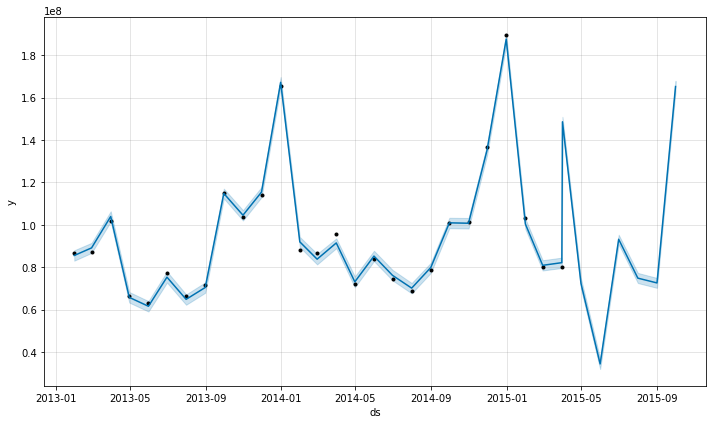

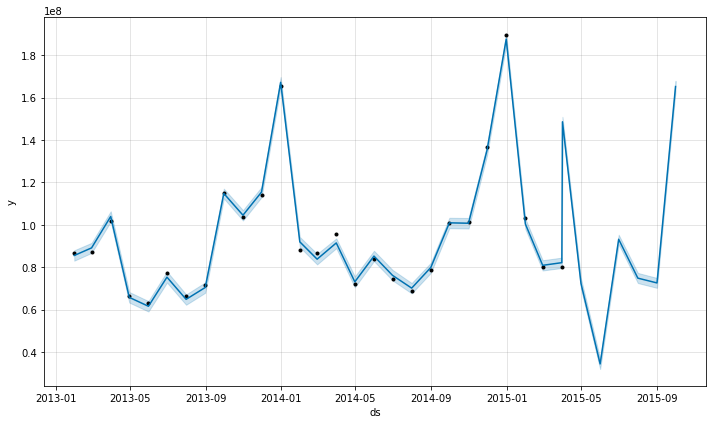

In [309]:
model.plot(forecast)

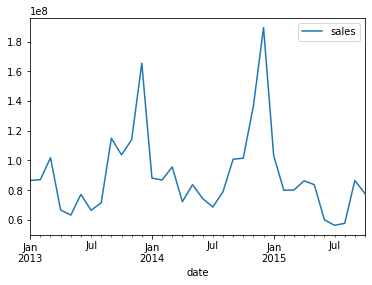

In [312]:
sales_gm.plot()

In [314]:
y_pred = forecast[['ds', 'yhat_lower']].tail(7)

In [317]:
y_pred.columns = ['date', 'sales']

In [321]:
y_pred=y_pred.set_index('date')

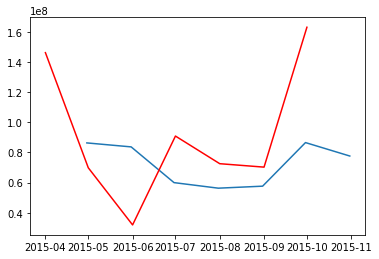

In [323]:
plt.plot(X_test_m)
plt.plot(y_pred,color='red')

## Conclusion
After several attempts, using both ARIMA and Prophet, we concluded this data is not ideal for time-serie predictions. We attempted removing outliers to make sure the data represents a general trend of the sales behavior, but still could not make the models to make accurate prediction. 

We can conclude that there are not enough trends presented in the data, this could be due to the company was constantly making random changes to their maketing strategies, making the sales data preseting random behaviors. Or the company replies purely on organic grow and there isn't enought data presented in the provided dataset for accurate time-series predictions.

In conclusion, time-series is not a good approach for this data, should use other means, regression or CNN.